In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%cd "/content/drive/My Drive/Colab Notebooks/slGan"

/content/drive/My Drive/Colab Notebooks/slGan


In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import time
from pathlib import Path
from PIL import Image
from tensorflow.contrib.learn.python.learn.datasets import mnist
import csv

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


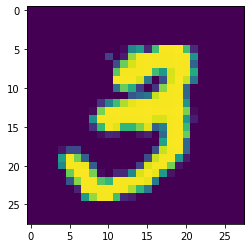

In [13]:
dataset = mnist.read_data_sets('MNIST_data', one_hot=True)
img = np.array(dataset.train.images[753])
plt.imshow(img.reshape(28,28))

In [0]:
def batch_norm(X, scale, offset, axes, is_train):
    # 予測のときにはそのまんまの値を返す
    if is_train is False:
        return X

    epsilon = 1e-5
    mean, variance = tf.nn.moments(X, axes)
    bn = tf.nn.batch_normalization(X, mean, variance, offset, scale,epsilon)

    return bn

class Generator():
    def __init__(self):

        # Generator parameter
        self.gen_w0 = tf.Variable(
            tf.random_normal(
                shape=[100,4*4*256], stddev=0.02, dtype=tf.float32),
            name="gen_w0")

        self.gen_b0 = tf.Variable(
            tf.random_normal(
                shape=[4*4*256], stddev=0.02, dtype=tf.float32),
            name="gen_b0")    
                  
        self.gen_w1 = tf.Variable(
            tf.random_normal(
                shape=[4, 4, 128, 256], stddev=0.02, dtype=tf.float32),
            name="gen_w1")
        
        self.gen_b1 = tf.Variable(
            tf.random_normal(
                shape=[128], stddev=0.02, dtype=tf.float32),
            name="gen_b1")
        
        self.gen_w2 = tf.Variable(
            tf.random_normal(
                shape=[4, 4, 64, 128], stddev=0.02, dtype=tf.float32),
            name="gen_w2")
        
        self.gen_b2 = tf.Variable(
            tf.random_normal(
                shape=[64], stddev=0.02, dtype=tf.float32),
            name="gen_b2")
        
        self.gen_w3 = tf.Variable(
            tf.random_normal(
                shape=[4, 4, 1, 64], stddev=0.02, dtype=tf.float32),
            name="gen_w3")
        
        self.gen_b3 = tf.Variable(
            tf.random_normal(
                shape=[1], stddev=0.02, dtype=tf.float32),
            name="gen_b3")          
        
        self.gen_scale_w0 = tf.Variable(
            tf.ones([256]), name="gen_scale_w0")
        self.gen_offset_w0 = tf.Variable(
            tf.zeros([256]), name="gen_offset_w0")
        
        self.gen_scale_w1 = tf.Variable(
            tf.ones([128]), name="gen_scale_w1")
        self.gen_offset_w1 = tf.Variable(
            tf.zeros([128]), name="gen_offset_w1")

        self.gen_scale_w2 = tf.Variable(
            tf.ones([64]), name="gen_scale_w2")
        self.gen_offset_w2 = tf.Variable(
            tf.zeros([64]), name="gen_offset_w2")

        self.keep_prob = tf.placeholder(tf.float32)
        self.batch_size = tf.placeholder(tf.int32)
            
    def run(self, z, is_train):

        h0 = tf.reshape(tf.nn.relu(tf.nn.xw_plus_b(z, self.gen_w0, self.gen_b0)),[-1,4,4,256])
                    
        gen_conv1 = tf.nn.conv2d_transpose(
                value=h0,
                filter=self.gen_w1,
                output_shape=[self.batch_size,7,7,128],
                strides=[1, 2, 2, 1],
                padding='SAME')+self.gen_b1
        
        h1 = tf.nn.leaky_relu(batch_norm(gen_conv1, self.gen_scale_w1, self.gen_offset_w1,
                        [0, 1, 2], is_train),alpha=0.2)
        
        gen_conv2 = tf.nn.conv2d_transpose(
                value=h1,
                filter=self.gen_w2,
                output_shape=[self.batch_size,14,14,64],
                strides=[1, 2, 2, 1],
                padding='SAME')+self.gen_b2
            
        h2 = tf.nn.leaky_relu(batch_norm(gen_conv2, self.gen_scale_w2, self.gen_offset_w2,
                                          [0, 1, 2], is_train),alpha=0.2)
        
        gen_conv3 = tf.nn.tanh(
            tf.nn.conv2d_transpose(
                value=h2,
                filter=self.gen_w3,
                output_shape=[self.batch_size,28,28,1],
                strides=[1, 2, 2, 1],
                padding='SAME')+self.gen_b3)
        
        return gen_conv3

class Discrimitor():
    def __init__(self):
        # Discrimitor parameter
        self.dis_w1 = tf.Variable(
            tf.random_normal(
                shape=[4, 4, 1, 64], stddev=0.02, dtype=tf.float32),
            name="dis_w1")
        
        self.dis_b1 = tf.Variable(
            tf.random_normal(
                shape=[64], stddev=0.02, dtype=tf.float32),
            name="dis_b1")
        
        self.dis_w2 = tf.Variable(
            tf.random_normal(
                shape=[4, 4, 64, 128], stddev=0.02, dtype=tf.float32),
            name="dis_w2")
        
        self.dis_b2 = tf.Variable(
            tf.random_normal(
                shape=[128], stddev=0.02, dtype=tf.float32),
            name="dis_b2")
        
        self.dis_w3 = tf.Variable(
            tf.random_normal(
                shape=[4, 4, 128, 256], stddev=0.02, dtype=tf.float32),
            name="dis_w3")
        
        self.dis_b3 = tf.Variable(
            tf.random_normal(
                shape=[256], stddev=0.02, dtype=tf.float32),
            name="dis_b3")
        
        self.dis_w4 = tf.Variable(
            tf.random_normal(
                shape=[4*4*256,1], stddev=0.02, dtype=tf.float32),
            name="dis_w4")
        
        self.dis_b4 = tf.Variable(
            tf.random_normal(
                shape=[1], stddev=0.02, dtype=tf.float32),
            name="dis_b4")

    def run(self, x, is_train):
        input_layer = tf.reshape(x, [-1, 28, 28, 1])
        dis_conv1 = tf.nn.conv2d(
                input=input_layer,
                filter=self.dis_w1,
                strides=[1, 2, 2, 1],
                padding='SAME')+self.dis_b1
        
        h1 = tf.nn.leaky_relu(dis_conv1,alpha=0.2)

        dis_conv2 = tf.nn.conv2d(
                input=h1,
                filter=self.dis_w2,
                strides=[1, 2, 2, 1],
                padding='SAME')+self.dis_b2

        h2 =tf.nn.leaky_relu(dis_conv2,alpha=0.2)     
    
        dis_conv3 = tf.nn.conv2d(
                input=h2,
                filter=self.dis_w3,
                strides=[1, 2, 2, 1],
                padding='SAME')+self.dis_b3
        
        h3 = tf.nn.leaky_relu(dis_conv3,alpha=0.2)
  
        h3_flat = tf.reshape(h3,[-1,4*4*256])
        fc = tf.nn.sigmoid(tf.nn.xw_plus_b(h3_flat,weights=self.dis_w4,biases=self.dis_b4))
            
        return fc


class DCGAN():
    def __init__(self):

        self.G_is_train = tf.placeholder(tf.bool)
        self.D_is_train = tf.placeholder(tf.bool)
        self.input_X = tf.placeholder(tf.float32, shape=(None, 28 * 28))

        # t0は0のラベルを格納し、t1は1のラベルを格納する
        self.label_t0 = tf.placeholder(tf.float32, shape=(None, 1))
        self.label_t1 = tf.placeholder(tf.float32, shape=(None, 1))

        # Generator
        self.generator = Generator()
        # 生成モデルに必要なノイズの入れ物
        self.gen_z = tf.placeholder(tf.float32, shape=(None, 100))
        # Discrimitor
        self.discrimitor = Discrimitor()

        # weight decay
        gen_norm_term = tf.nn.l2_loss(self.generator.gen_w2) + tf.nn.l2_loss(self.generator.gen_w3)
        gen_lambda_ = 0.001

        dis_norm_term = tf.nn.l2_loss(self.discrimitor.dis_w2) + tf.nn.l2_loss(self.discrimitor.dis_w3)
        dis_lambda_ = 0.001

        # 訓練データの識別予測
        input_X = self.discrimitor.run(
            self.input_X,
            is_train=self.D_is_train)
        
        # 生成されたデータの識別予測
        generated_X = self.discrimitor.run( self.generator.run(z=self.gen_z, is_train=self.G_is_train), is_train=self.D_is_train)

        self.dis_entropy_X = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.label_t1, logits=input_X)
        self.dis_entropy_G = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.label_t0, logits=generated_X)
        self.dis_loss = tf.reduce_mean(
            self.dis_entropy_X + self.dis_entropy_G
        ) + dis_norm_term * dis_lambda_

        self.gen_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=self.label_t1, logits=generated_X)
        self.gen_loss = tf.reduce_mean(
            self.gen_entropy) #+ gen_norm_term * gen_lambda_

        # 最適化する際にDならDのみのパラメータを、GならGのみのパラメータを更新するようにしたいのでモデル別の変数を取得する
        dis_vars = [
            x for x in tf.trainable_variables() if "dis_" in x.name
        ]
        gen_vars = [
            x for x in tf.trainable_variables() if "gen_" in x.name
        ]

        # 識別モデルDの最適化
        self.opt_d = tf.train.AdamOptimizer(0.0002,beta1=0.1).minimize(
                self.dis_loss, var_list=[dis_vars])
        # 生成モデルGの最適化
        self.opt_g = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(
                self.gen_loss, var_list=[gen_vars])
                                   
    def train(self,
              X_train=None,
              batch_size=100,
              epoch_num=1000,
              imgpath='./mnist_DCGAN_images/',
              ckptpath='./mnist_DCGAN_checkpoints/',
              log_file='mnist_DCGAN_loss_log.csv',
              init=False):

        if X_train is None:
            raise TypeError("X_train is None")

        # 訓練途中で生成データを作成して保存したいのでその保存先の作成
        p = Path(imgpath)
        if not (p.is_dir()):
            p.mkdir()

        # モデルパラメータのチェックポイントの保存先
        ckpt_p = Path(ckptpath)
        if not (ckpt_p.is_dir()):
            ckpt_p.mkdir()

        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        saver = tf.train.Saver()

        sess = tf.Session()

        if (init):
            sess.run(tf.global_variables_initializer())
            print('Initialize')

        ckpt = tf.train.get_checkpoint_state(str(ckpt_p.absolute()))
        if ckpt:
            # checkpointファイルから最後に保存したモデルへのパスを取得する
            last_model = ckpt.model_checkpoint_path
            print("load {0}".format(last_model))
            # 学習済みモデルを読み込む
            saver.restore(sess, last_model)

        step = len(X_train) // batch_size
        #step = mnist.train.num_examples // batch_size

        # 正解ラベルのミニバッチ
        t1_batch = np.ones((batch_size, 1), dtype=np.float32)
        t0_batch = np.zeros((batch_size, 1), dtype=np.float32)

        for epoch in range(epoch_num):

            perm = np.random.permutation(len(X_train))
            # １エポックごとにかかる時間の計測
            start = time.time()
            for k in range(step):
                #X_batch = mnist.train.next_batch(batch_size)[0] /255.
                X_batch = X_train[perm][k * batch_size:(k + 1) * batch_size]

                # Train Discrimitor
                # ノイズ事前分布からノイズをミニバッチ分取得
                noise_z = np.random.uniform(
                    -1, 1, size=[batch_size,100]).astype(np.float32)

                sess.run(
                    self.opt_d,
                    feed_dict={
                        self.input_X: X_batch,
                        self.D_is_train: True,
                        self.G_is_train: False,
                        self.gen_z: noise_z,
                        self.generator.keep_prob: 1.0,
                        self.generator.batch_size: batch_size,
                        self.label_t1: t1_batch,
                        self.label_t0: t0_batch
                    })

                if k % 1 == 0:
                    # Train Generator
                    # ノイズ事前分布からノイズをミニバッチ分取得
                    noise_z = np.random.uniform(
                        -1, 1, size=[batch_size,100]).astype(np.float32)
                    sess.run(
                        self.opt_g,
                        feed_dict={
                            self.gen_z: noise_z,
                            self.D_is_train: False,
                            self.G_is_train: True,
                            self.generator.keep_prob: 0.5,
                            self.generator.batch_size: batch_size,
                            self.label_t1: t1_batch
                        })

            # 1epoch終了時の損失を表示
            noise_z = np.random.uniform(
                -1, 1, size=[batch_size,100]).astype(np.float32)
            train_dis_loss = sess.run(
                self.dis_loss,
                feed_dict={
                    self.input_X: X_batch,
                    self.D_is_train: False,
                    self.G_is_train: False,
                    self.gen_z: noise_z,
                    self.generator.keep_prob: 1.0,
                    self.generator.batch_size: batch_size,
                    self.label_t1: t1_batch,
                    self.label_t0: t0_batch
                })

            train_gen_loss = sess.run(
                self.gen_loss,
                feed_dict={
                    self.gen_z: noise_z,
                    self.D_is_train: False,
                    self.G_is_train: False,
                    self.generator.keep_prob: 1.0,
                    self.generator.batch_size: batch_size,
                    self.label_t1: t1_batch
                })
            print(
                "[Train] epoch: %d, dis loss: %f , gen loss : %f  Time : %f" %
                (epoch, train_dis_loss, train_gen_loss, time.time() - start))

            # ファイルオープン
            f = open(log_file, 'a')
            log_writer = csv.writer(f, lineterminator='\n')
            loss_list = []
            loss_list.append(epoch)
            loss_list.append(train_dis_loss)
            loss_list.append(train_gen_loss)
            # 損失の値を書き込む
            log_writer.writerow(loss_list)
            f.close()

            saver.save(sess, str(ckpt_p.absolute()) + '/DCGAN-mnist')

            # 10epoch終了毎に生成モデルから1枚の画像を生成する
            if epoch % 2 == 0:
                noise_z = np.random.uniform(
                    -1,1, size=[5,100]).astype(np.float32)

                z_const = tf.constant(noise_z, dtype=tf.float32)
                gen_imgs = ((sess.run(
                    self.generator.run(z_const, is_train=False),
                    feed_dict={self.generator.keep_prob: 1.0,self.generator.batch_size: 5})* 0.5)+0.5)*255.
                for i in range(0,5):
                    Image.fromarray(gen_imgs[i].reshape(
                        28, 28)).convert('RGB').save(
                            str(p.absolute()) +
                            '/generate_img_epoch{0}_{1}.jpg'.format(epoch,i))

In [15]:
X_train = (dataset.train.images - 0.5 ) / 0.5
len(X_train)

55000

In [17]:
model = DCGAN()
model.train(
    X_train=X_train[:30000],
    batch_size=100,
    epoch_num=51,
    init=True)

Initialize
[Train] epoch: 0, dis loss: 1.495829 , gen loss : 0.691980  Time : 465.975002
[Train] epoch: 1, dis loss: 1.465094 , gen loss : 0.693017  Time : 466.687557
[Train] epoch: 2, dis loss: 1.440944 , gen loss : 0.692981  Time : 467.580492
[Train] epoch: 3, dis loss: 1.423931 , gen loss : 0.692743  Time : 468.460238
[Train] epoch: 4, dis loss: 1.675496 , gen loss : 0.314967  Time : 466.270964
[Train] epoch: 5, dis loss: 1.252660 , gen loss : 0.576094  Time : 466.938187
[Train] epoch: 6, dis loss: 1.192623 , gen loss : 0.608426  Time : 466.730093
[Train] epoch: 7, dis loss: 1.421707 , gen loss : 0.693088  Time : 468.103709
[Train] epoch: 8, dis loss: 1.412241 , gen loss : 0.693083  Time : 467.351118
[Train] epoch: 9, dis loss: 1.406177 , gen loss : 0.693017  Time : 467.369264
[Train] epoch: 10, dis loss: 1.339267 , gen loss : 0.495425  Time : 472.748704
[Train] epoch: 11, dis loss: 1.297050 , gen loss : 0.579046  Time : 467.374798
[Train] epoch: 12, dis loss: 1.281781 , gen loss : 